In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : Catboost    ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

     |████████████████████████████████| 24.2 MB 1.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 76.6 MB 101 kB/s 


In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

In [ ]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

In [ ]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

In [ ]:
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_sentPosNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL/

In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [ ]:
################################################################################
######################     Catboost Optuna HPO  ################################
######################         100 trials       ################################
################################################################################
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
    }

    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU', 
        random_state=seed_value,
        **params_catboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [21]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL/

study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL
Number of finished trials: 49
Best trial: {'iterations': 410, 'depth': 10, 'l2_leaf_reg': 1.0718086375197874e-08, 'learning_rate': 0.05375054590905357, 'min_data_in_leaf': 19, 'one_hot_max_size': 13, 'scale_pos_weight': 0.8185812766841374}
Lowest LogLoss 0.16307071775742057


In [22]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=51)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
21:	learn: 0.3518081	test: 0.3530000	best: 0.3530000 (21)	total: 383ms	remaining: 7.11s
22:	learn: 0.3448389	test: 0.3460509	best: 0.3460509 (22)	total: 399ms	remaining: 7.07s
23:	learn: 0.3381490	test: 0.3393831	best: 0.3393831 (23)	total: 418ms	remaining: 7.07s
24:	learn: 0.3320717	test: 0.3333100	best: 0.3333100 (24)	total: 436ms	remaining: 7.07s
25:	learn: 0.3262447	test: 0.3275220	best: 0.3275220 (25)	total: 453ms	remaining: 7.03s
26:	learn: 0.3207795	test: 0.3220735	best: 0.3220735 (26)	total: 469ms	remaining: 7s
27:	learn: 0.3155527	test: 0.3168834	best: 0.3168834 (27)	total: 485ms	remaining: 6.96s
28:	learn: 0.3105929	test: 0.3119467	best: 0.3119467 (28)	total: 503ms	remaining: 6.95s
29:	learn: 0.3058400	test: 0.3071953	best: 0.3071953 (29)	total: 522ms	remaining: 6.96s
30:	learn: 0.3015087	test: 0.3028696	best: 0.3028696 (30)	total: 539ms	remaining: 6.94s
31:	learn: 0.2974100	test: 0.2987802	best: 0.2987802 (31)	total: 556ms	r

In [23]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions


In [24]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_depth':'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg':'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf':'min_data_in_leaf'}, inplace=True)
trials_df.rename(columns={'params_one_hot_max_size':'one_hot_max_size'}, inplace=True)
trials_df.rename(columns={'params_scale_pos_weight':'scale_pos_weight'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
58         58  0.160526 2022-05-14 12:31:28.674318 2022-05-14 12:33:07.087235   
75         75  0.160633 2022-05-14 12:59:01.852021 2022-05-14 13:00:40.458200   
96         96  0.160660 2022-05-14 13:33:35.427589 2022-05-14 13:35:14.952976   
74         74  0.161213 2022-05-14 12:57:23.069310 2022-05-14 12:59:01.851889   
86         86  0.161389 2022-05-14 13:16:59.751912 2022-05-14 13:18:38.730543   
..        ...       ...                        ...                        ...   
3           3  0.692699 2022-05-14 03:45:56.573916 2022-05-14 03:47:37.770798   
30         30  0.692887 2022-05-14 11:15:27.855206 2022-05-14 11:16:59.836745   
25         25  0.706850 2022-05-14 11:07:42.124348 2022-05-14 11:09:17.962009   
21         21       NaN 2022-05-14 04:16:56.419436                        NaT   
48         48       NaN 2022-05-14 11:44:28.423948                        NaT   

                 duration  

In [25]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations


In [26]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [27]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [28]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [29]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [30]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions


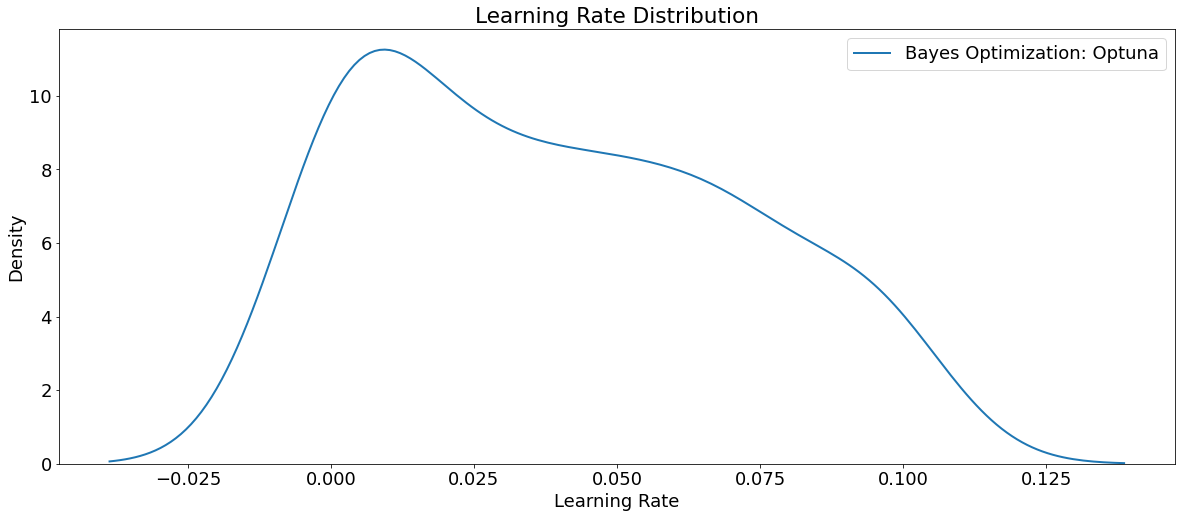

In [31]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

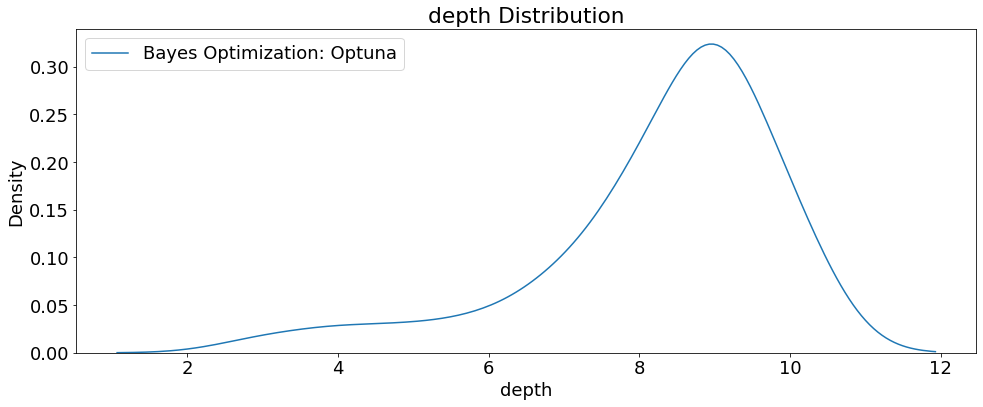

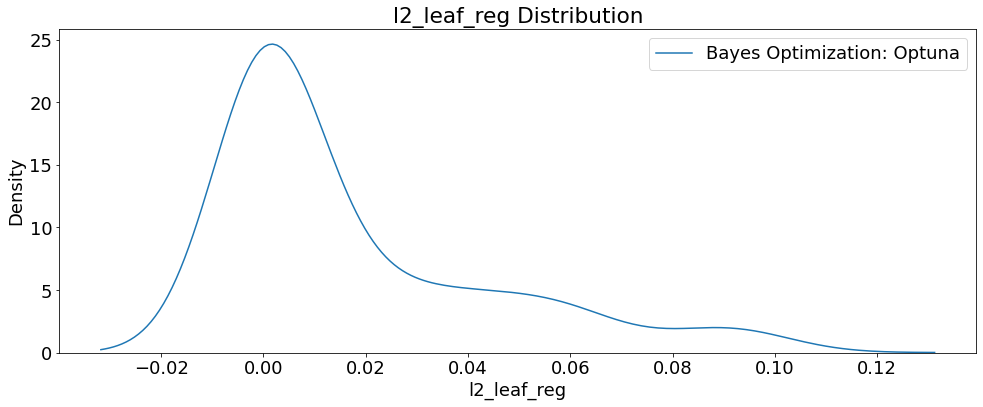

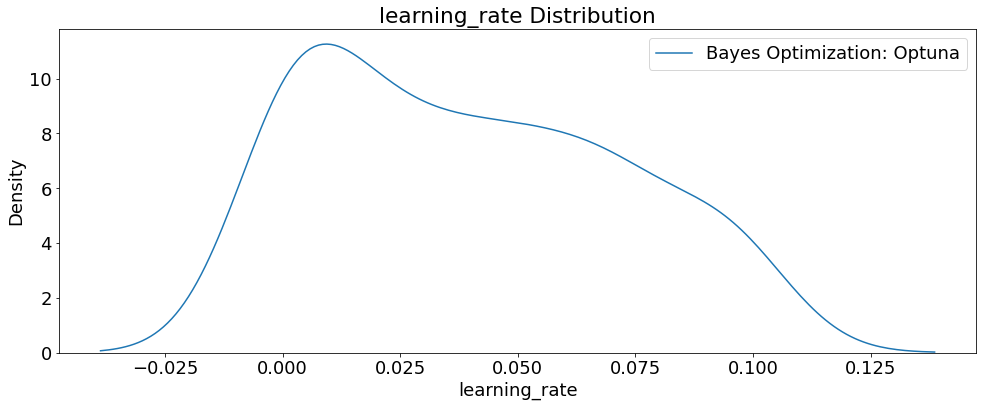

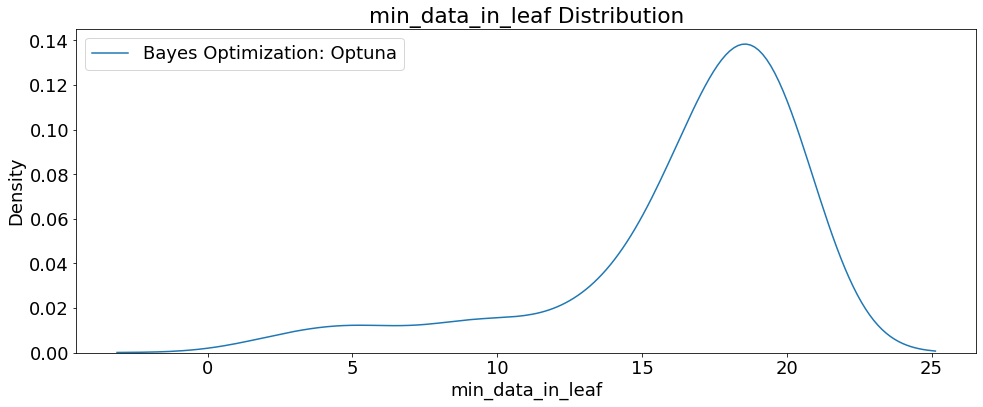

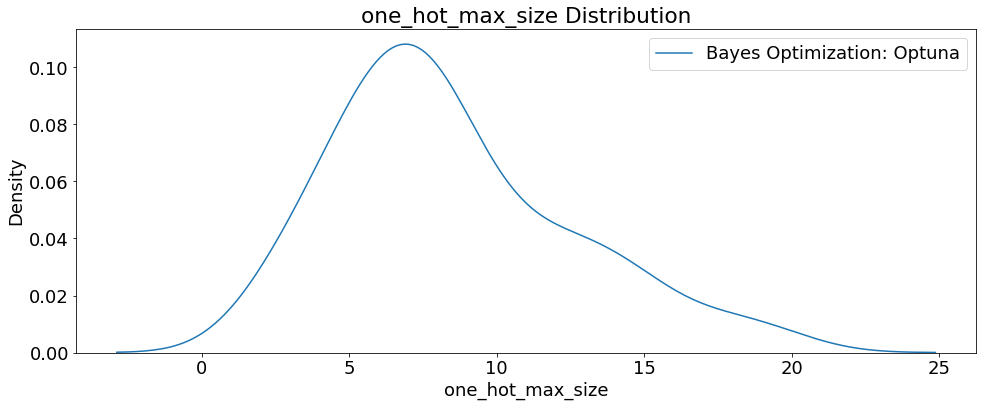

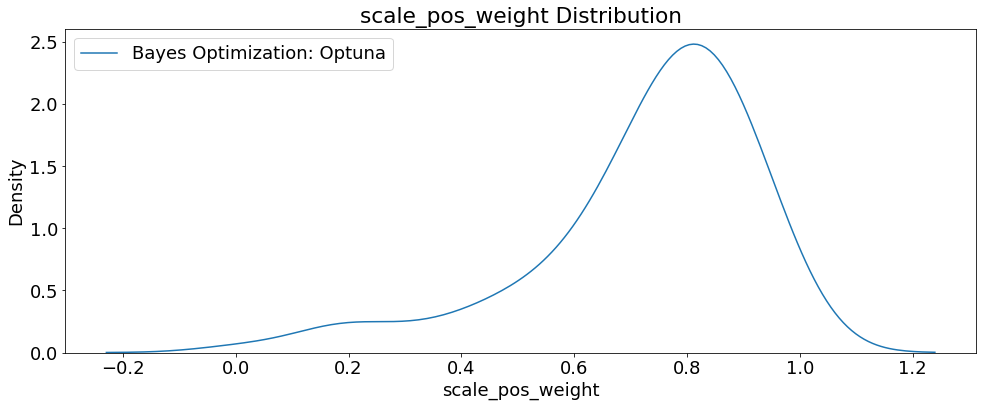

In [32]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



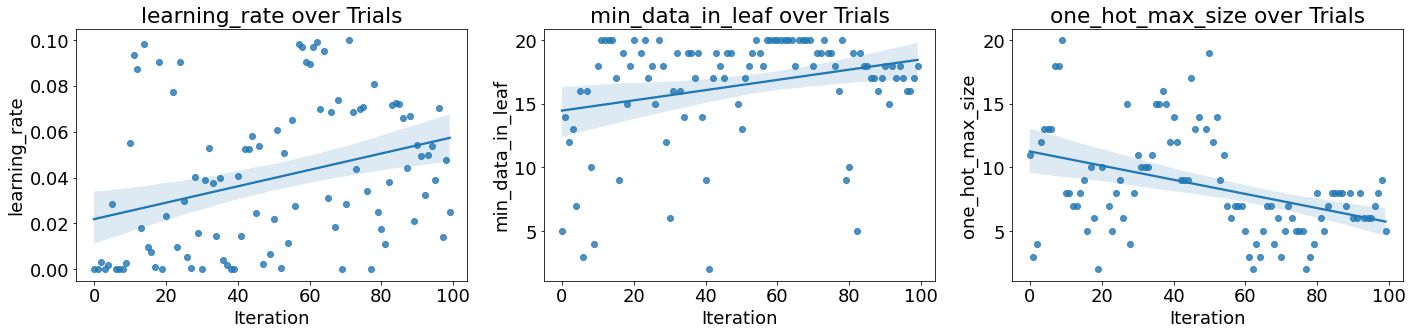

In [33]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



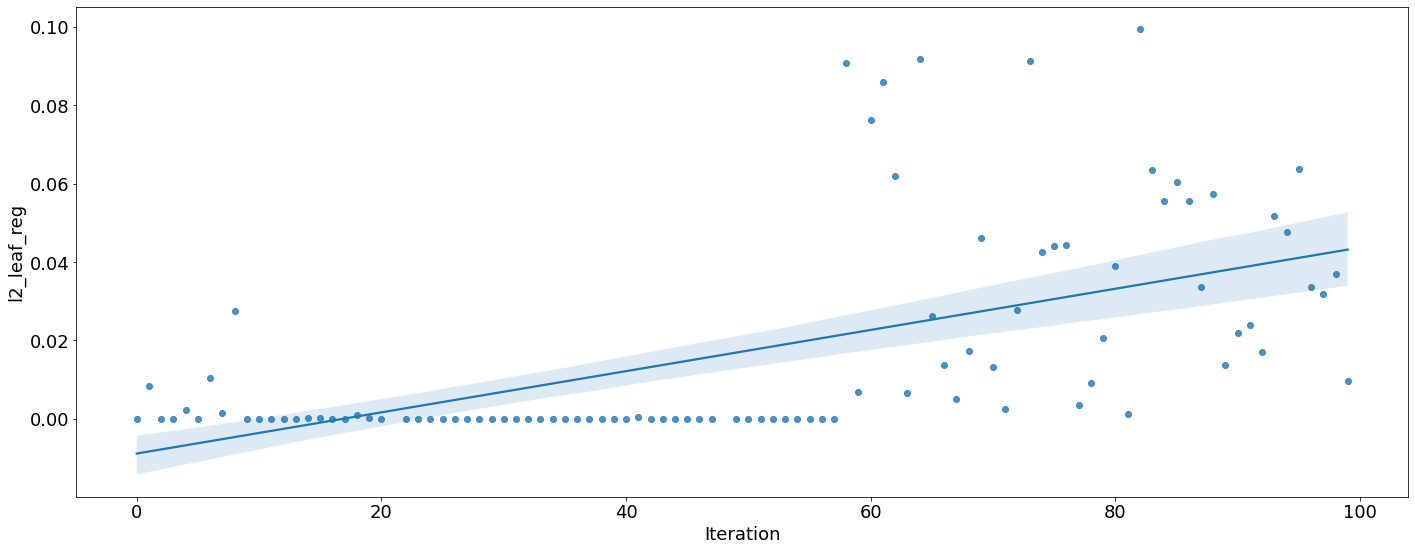

In [34]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = trials_df, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [35]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations


In [36]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [37]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [38]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 9,
 'iterations': 400,
 'l2_leaf_reg': 0.09068084631501748,
 'learning_rate': 0.09709794282866532,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 20,
 'one_hot_max_size': 7,
 'random_state': 42,
 'scale_pos_weight': 0.8156227654890045}

In [39]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL/


study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL


In [40]:
label = df[['stars_reviews']]

features = df.cleanReview

In [41]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [42]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [43]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(early_stopping_rounds=100,
                               rsm=1, 
                               task_type='GPU', 
                               logging_level='Silent', 
                                **params)
# Fit the model
#.ravel()
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
# print(model)
# =============================================================================

In [44]:
print('Results from Catboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    331950
         1.0       0.95      0.94      0.95    331949

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[317002  14948]
 [ 19815 312134]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     82987
         1.0       0.94      0.93      0.94     82988

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78392  4595]
 [ 5815 77173]]


Accuracy score: train: 0.948, test: 0.937
Precision score: train: 0.954, test: 0.944
Recall score: train: 0.940, test

In [45]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions


In [46]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93728 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    58
logloss                                0.160526
datetime_start       2022-05-14 12:31:28.674318
datetime_complete    2022-05-14 12:33:07.087235
duration                 0 days 00:01:38.412917
depth                                       9.0
n_estimators                              400.0
l2_leaf_reg                            0.090681
learning_rate                          0.097098
min_data_in_leaf                           20.0
one_hot_max_size                            7.0
scale_pos_weight                       0.815623
state                                  COMPLETE
Name: 0, dtype: object
